# Fitted Q-learning algo

Below is a version of the fitted Q-Learning algorithm described [last time]((https://www.dropbox.com/s/3qjqhpo1mix0w9h/deep_QLearning_part_2_SLIDES.pdf?dl=0).  Recall the main variation here is just this: instead of updating $Q$ *inside* each episode, we wait (at least) until the end of the episode to update.  

A few quirks of this implementation:
- its written in PyTorch
- The size of memory for memory replay is fixed at a number of episodes instead of a number of steps.  
- There are a large number of user-controls - defined in the initialization - that allow for a wide range of use, including parameters to control how often the weights of $Q$ are saved, how often $Q$ is updated (in terms of number of episodes),...

In [1]:
import numpy as np
import copy
import os
import pickle
import torch
from torch.autograd import Variable
import gym

'''
PyTorch does not the same abstract API Keras does for optimization, in particular
while it does contain an array of advanced first order methods like e.g., RMSprop
one needs to construct one's own looping structure in order to employ it properly. 
Below the class My_Opt does just this.  
'''
class My_Opt:
    def __init__(self,model,cost):
        self.model = model
        self.cost = cost
        learning_rate = 10**(-2)
        self.optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
        
        # record history
        self.cost_history = []
        self.weight_history = []
        
    def fit(self,x,y,max_its,lr):
        # update learning rate
        self.optimizer.param_groups[0]['lr'] = lr
        
        for t in range(max_its):
            # Forward pass: compute predicted y by passing x to the model.
            y_pred = self.model(x.float())

            # Compute and print loss.
            cost_val = self.cost(y_pred, y.float())
            self.optimizer.zero_grad()

            if len(self.cost_history) == 0 or t > 0:
                # store weight and cost history
                self.cost_history.append(cost_val.data.item())
                self.weight_history.append(self.optimizer.param_groups[0]['params'])

            # Backward pass: compute gradient of the loss with respect to model
            # parameters
            cost_val.backward()

            # Calling the step function on an Optimizer makes an update to its
            # parameters
            self.optimizer.step()

        # collect last input / weights
        y_pred = self.model(x.float())
        cost_val = self.cost(y_pred, y.float())
        self.cost_history.append(cost_val.data.item())
        self.weight_history.append(self.optimizer.param_groups[0]['params'])

class QLearner():
    # load in simulator, initialize global variables
    def __init__(self,gymname,dirname,savename,**kwargs):
        # load in gym simulator
        self.simulator = gym.make(gymname) 
             
        # Q learn basic params
        self.explore_val = 1       # how often should an action be chosen randomly vs using the optimal control law, larger values mean actions are more often chosen randomly
        self.explore_decay = 0.99  # after each episode the explore_val is multiplied by explore_decay to (potentially) shrink it
        self.gamma = 1             # short-term/long-term trade-off param
        self.num_episodes = 500    # number of episodes of simulation to perform
        self.save_weight_freq = 10 # controls how often (in number of episodes) the weights of $Q$ are saved 
        self.memory = []           # memory container
        
        # fitted Q-Learning params
        self.episode_update = 1     # after how many episodes should we update Q?
        self.memory_length = 10     # length of memory replay (in episodes)

        # simulation-specific params
        self.exit_level = 200       # sets the optimal episode reward required for 'success'
        self.exit_window = 100      # sets the window over which average total reward per episode must be >= exit_level  to deem Q resolved successfully
        
        # let user define each of the params above
        if "gamma" in kwargs:   
            self.gamma = args['gamma']
        if 'explore_val' in kwargs:
            self.explore_val = kwargs['explore_val']
        if 'explore_decay' in kwargs:
            self.explore_decay = kwargs['explore_decay']
        if 'num_episodes' in kwargs:
            self.num_episodes = kwargs['num_episodes']
        if 'episode_update' in kwargs:
            self.episode_update = kwargs['episode_update']
        if 'exit_level' in kwargs:
            self.exit_level = kwargs['exit_level']
        if 'exit_window' in kwargs:
            self.exit_window = kwargs['exit_window']  
        if 'save_weight_freq' in kwargs:
            self.save_weight_freq = kwargs['save_weight_freq']
        if 'memory_length' in kwargs:
            self.memory_length = kwargs['memory_length']
        if 'episode_update' in kwargs:
            self.episode_update = kwargs['episode_update']
            
        # get simulation-specific variables from simulator
        self.num_actions = self.simulator.action_space.n
        state = self.simulator.reset()    
        self.state_dim = np.size(state)
        self.training_reward = []
            
        ### initialize logs ###
        # create text file for training log
        self.logname = dirname + '/training_logs/' + savename + '.txt'
        self.reward_logname = dirname + '/reward_logs/' + savename + '.txt'
        self.weight_name = dirname + '/saved_model_weights/' + savename + '.pkl' 
        self.model_name = dirname + '/models/' + savename + '.json'

        self.init_log(self.logname)
        self.init_log(self.reward_logname)
        self.init_log(self.weight_name)
        self.init_log(self.model_name)
     
    ##### logging functions #####
    def init_log(self,logname):
        # delete log if old version exists
        if os.path.exists(logname): 
            os.remove(logname)
            
    def update_log(self,logname,update):
        if type(update) == str:
            logfile = open(logname, "a")
            logfile.write(update)
            logfile.close() 
        else:
            weights = []
            if os.path.exists(logname):
                with open(logname,'rb') as rfp: 
                    weights = pickle.load(rfp)
            weights.append(update)

            with open(logname,'wb') as wfp:
                pickle.dump(weights, wfp)
    
    ##### functions for creating / updating Q #####
    def initialize_Q(self,**kwargs):
        # default parameters for network
        layer_sizes = [10,10]      # two hidden layers, 10 units each, by default
        activation = 'relu'
        if 'layer_sizes' in kwargs:
            layer_sizes = kwargs['layer_sizes']
        if 'activation' in kwargs:
            activation = kwargs['activation']

        # default parameters for optimizer - reset by hand
        loss = 'mse'
        self.lr = 10**(-2)
        if 'alpha' in kwargs:
            self.lr = kwargs['alpha']

        # input / output sizes of network
        input_dim = self.state_dim
        output_dim = self.num_actions

        # Use the nn package to define our model and loss function
        self.model = torch.nn.Sequential()

        # add input layer
        self.model.add_module('linear ' + str(0),torch.nn.Linear(input_dim,layer_sizes[0]))
        if activation == 'relu':
            self.model.add_module('activation ' + str(0),torch.nn.ReLU())
        if activation == 'tanh':
            self.model.add_module('activation ' + str(0),torch.nn.Tanh())

        # add hidden layers
        for i in range(1,len(layer_sizes)):
            U = layer_sizes[i-1]
            V = layer_sizes[i]
            self.model.add_module('linear ' + str(i),torch.nn.Linear(U,V))
            if activation == 'relu':
                self.model.add_module('activation ' + str(i),torch.nn.ReLU())
            if activation == 'tanh':
                self.model.add_module('activation ' + str(i),torch.nn.Tanh())

        # add output layer
        self.model.add_module('linear ' + str(len(layer_sizes)),torch.nn.Linear(layer_sizes[-1], output_dim))

        # define cost function
        self.cost = torch.nn.MSELoss(size_average=True)
        
        # setup optimizer - using hand-made optimizer class + RMSprop
        self.opt = My_Opt(self.model,self.cost)

        # initialize Q
        self.Q = self.opt.model.forward

    # update Q function
    def update_Q(self):        
        # generate q_values based on most recent Q
        q_vals = []
        states = []
        for i in range(len(self.memory)):    
            # get episode_data
            episode_data = self.memory[i]
            
            # loop over episode data and create input/output pairs
            for j in range(len(episode_data)):
                # get next sample of episode
                sample = episode_data[j]
            
                # strip sample for parts
                state = sample[0]
                next_state = sample[1]
                action = sample[2]
                reward = sample[3]
                done = sample[4]

                ### for cartpole only - check if done, and alter reward to improve learning ###
                done,reward = self.check_done(done,reward)

                # compute and store q value
                q = reward 
                if done == False:
                    next_state = Variable(torch.from_numpy(next_state),requires_grad=False)        
                    qs = self.Q(next_state.float()).detach().numpy()
                    q += self.gamma*np.max(qs)

                # clamp all other models to their current values for this input/output pair
                state = Variable(torch.from_numpy(state),requires_grad=False)        
                q_update = self.Q(state.float()).detach().numpy().flatten()
                q_update[action] = q
                q_vals.append(q_update)
                states.append(state.numpy().flatten())

        # convert lists to numpy arrays for regressor
        states = np.array(states).T
        states = torch.from_numpy(states)
        s_in = Variable(states,requires_grad = False)
        q_vals = np.array(q_vals).T
        q_vals = torch.from_numpy(q_vals)
        q_vals = Variable(q_vals,requires_grad = False)

        # take descent step
        self.opt.fit(s_in.t(),q_vals.t(),max_its = 1,lr=self.lr)

        # update Q based on regressor updates
        self.Q = self.opt.model.forward
        
    ##### functions for adjusting replay memory #####
    # update memory - add sample to list, remove oldest samples 
    def update_memory(self,episode_data):
        # add most recent trial data to memory
        self.memory.append(episode_data)

        # clip memory if it gets too long    
        num_episodes = len(self.memory)
        if num_episodes >= self.memory_length:    
            num_delete = num_episodes - self.memory_length
            self.memory[:num_delete] = []
    
    ##### Q Learning functionality #####
    # special function to check done
    def check_done(self,done,reward):
        if done == True:
            reward = -100
        return done,reward
    
    # state normalizer
    def state_normalizer(self,states):
        states = np.array(states)[np.newaxis,:]
        return states
    
    # choose next action
    def choose_action(self,state):
        # pick action at random
        p = np.random.rand(1)   
        action = np.random.randint(self.num_actions)
            
        # pick action based on exploiting - after memory full
        state = Variable(torch.from_numpy(state),requires_grad=False)        
        qs = self.Q(state.float()).detach().numpy()
        if p > self.explore_val:
            action = np.argmax(qs)
        return action
    
    # main training function
    def train(self,**kwargs):
            
        ### start main Q-learning loop ###
        for n in range(self.num_episodes): 
            # pick this episode's starting position - randomly initialize from f_system
            state = self.simulator.reset()    
            state = self.state_normalizer(state)
            total_episode_reward = 0
            done = False
            
            # get out exploit parameter for this episode
            if self.explore_val > 0.01:
                self.explore_val *= self.explore_decay
                    
            # run episode
            step = 0
            episode_data = []
            while done == False and step < 500:    
                # choose next action
                action = self.choose_action(state)
    
                # transition to next state, get associated reward
                next_state,reward,done,info = self.simulator.step(action)  
                next_state = self.state_normalizer(next_state)
                
                # store data for transition after episode ends
                episode_data.append([state,next_state,action,reward,done])

                # update total reward from this episode
                total_episode_reward+=reward
                state = copy.deepcopy(next_state)
                step += 1
                  
            # store this episode's computation time and training reward history
            self.training_reward.append(total_episode_reward)
            
            # update memory with this episode's data
            self.update_memory(episode_data)
            
            # update Q function
            if np.mod(n,self.episode_update) == 0:
                self.update_Q()  

            # update episode reward greater than exit_level, add to counter
            exit_ave = total_episode_reward
            if n >= self.exit_window:
                exit_ave = np.sum(np.array(self.training_reward[-self.exit_window:]))/self.exit_window

            ### print out updates ###
            update = 'episode ' + str(n+1) +  ' of ' + str(self.num_episodes) + ' complete, ' +  ' explore val = ' + str(np.round(self.explore_val,3)) + ', episode reward = ' + str(np.round(total_episode_reward,1)) + ', ave reward = ' + str(np.round(exit_ave,1))
  
            self.update_log(self.logname,update + '\n')
                              
            # print out updates 
            print (update)
            
            # record rewards
            update = str(total_episode_reward) + '\n'
            self.update_log(self.reward_logname,update)
            
            # save latest weights from this episode 
            if np.mod(n,self.save_weight_freq) == 0:
                update = self.opt.weight_history[-1]
                self.update_log(self.weight_name,update)
            
            # if the total episode reward is greater than exit level for 10 consecutive episodes, break
            if exit_ave >= self.exit_level and n >= self.exit_level:
                break
                            
        ### save weights ###
        update = 'q-learning algorithm complete'
        self.update_log(self.logname,update + '\n')
        print (update)

# Episode reward history plotter

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# moving average function
def moving_average(x,D):
    y = []
    for p in range(len(x)+1):
        # make next element
        b = np.sum(x[np.maximum(0,p-D):p])/float(D)
        y.append(b)
    return np.array(y)

def plot_reward_history(logname,**kwargs):
    start = 1
    window_length = 5
    if 'window_length' in kwargs:
        window_length = kwargs['window_length']
    if 'start' in kwargs:
        start = kwargs['start']
        
    # load in total episode reward history
    data = np.loadtxt(logname)
    ave = moving_average(data,window_length)

    # create figure
    fig = plt.figure(figsize = (12,8))
    ax1 = fig.add_subplot(2,1,1)
    ax2 = fig.add_subplot(2,1,2)

    # plot total reward history
    ax1.plot(data)
    ax1.set_xlabel('episode',labelpad = 8,fontsize = 13)
    ax1.set_ylabel('total reward',fontsize = 13)
    
    ave[:window_length] = np.nan
    ax2.plot(ave,linewidth=3)
    ax2.set_xlabel('episode',labelpad = 8,fontsize = 13)
    ax2.set_ylabel('ave total reward',fontsize=13)
    plt.show()

# Run fitted Q-Learning algo

In [3]:
# feed in current directory name and savename = experiment name
dirname = os.getcwd()
savename = 'qfitted_cartpole_experiment_1'
gymname = 'CartPole-v1'

# initialize Q Learn process
num_episodes = 1000
explore_decay = 1
explore_val = 0.01
exit_level = 200
exit_window = 100
save_weight_freq = 1000

# initialize memory
episode_update = 1
memory_length = 1

# load into instance of learner
demo = QLearner(gymname,dirname,savename,num_episodes=num_episodes,explore_decay=explore_decay,explore_val=explore_val,memory_length=memory_length,episode_update=episode_update,exit_level=exit_level,exit_window=exit_window,save_weight_freq=save_weight_freq)

# initialize Q function
layer_sizes = [50,50]
alpha = 10**(-2)
activation = 'relu'
demo.initialize_Q(layer_sizes=layer_sizes,alpha=alpha,activation=activation)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [4]:
demo.train()

episode 1 of 1000 complete,  explore val = 0.01, episode reward = 9.0, ave reward = 9.0
episode 2 of 1000 complete,  explore val = 0.01, episode reward = 74.0, ave reward = 74.0
episode 3 of 1000 complete,  explore val = 0.01, episode reward = 9.0, ave reward = 9.0
episode 4 of 1000 complete,  explore val = 0.01, episode reward = 13.0, ave reward = 13.0
episode 5 of 1000 complete,  explore val = 0.01, episode reward = 9.0, ave reward = 9.0
episode 6 of 1000 complete,  explore val = 0.01, episode reward = 13.0, ave reward = 13.0
episode 7 of 1000 complete,  explore val = 0.01, episode reward = 10.0, ave reward = 10.0
episode 8 of 1000 complete,  explore val = 0.01, episode reward = 10.0, ave reward = 10.0
episode 9 of 1000 complete,  explore val = 0.01, episode reward = 10.0, ave reward = 10.0
episode 10 of 1000 complete,  explore val = 0.01, episode reward = 22.0, ave reward = 22.0
episode 11 of 1000 complete,  explore val = 0.01, episode reward = 9.0, ave reward = 9.0
episode 12 of 10

# Plot total episode reward history

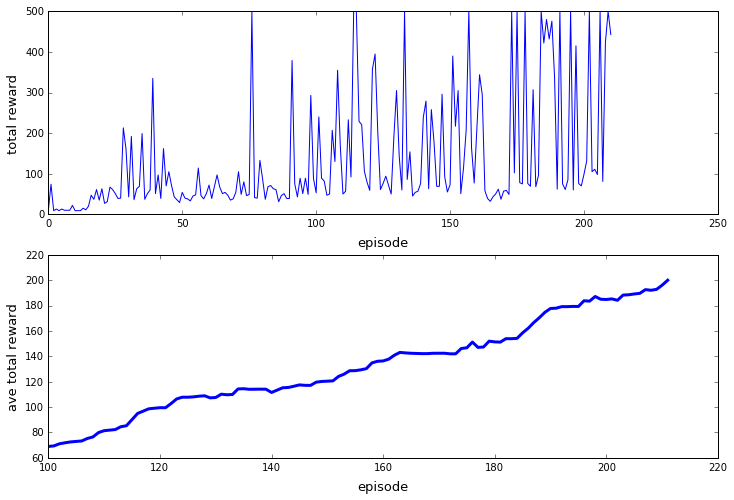

In [5]:
reward_logname = 'reward_logs/' + savename + '.txt'
plot_reward_history(reward_logname,window_length = exit_window)